<a href="https://colab.research.google.com/github/KazumaIwase/Interpolation-of-mountain-weather-forecasts-/blob/main/notebooks/experiment_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments on several models


Prediction object
*   Temperature prediction for Mt.Fuji
*   Precipitation prediction for Hakone


Models
*   Elastic Net
*   LightGBM
*   XGBoost
*   Extra Tree
*   Neural Network



In [1]:
!pip install optuna==3.2.0
!pip install lightgbm==3.3.5

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import optuna
import glob
import warnings
import time
import math
import random
import seaborn as sns
sns.set()
warnings.simplefilter('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 296326181574368983
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15181414400
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15488580693624692289
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

Clone our github repository and get datasets

In [3]:
!pwd

!git clone https://github.com/KazumaIwase/Interpolation-of-mountain-weather-forecasts-.git

!ls
%cd Interpolation-of-mountain-weather-forecasts-
!ls

/content
Cloning into 'Interpolation-of-mountain-weather-forecasts-'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 99 (delta 41), reused 53 (delta 15), pack-reused 0
Receiving objects: 100% (99/99), 7.11 MiB | 13.71 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Interpolation-of-mountain-weather-forecasts-  sample_data
/content/Interpolation-of-mountain-weather-forecasts-
data  dataset_tools  model  notebooks  README.md  utils


In [4]:
dataset = pd.read_csv('data/observe.csv', header=0, index_col=0, parse_dates=True)

In [5]:
import utils.exp_utils as ex
import model.model as model
import dataset_tools.make_dataset as md

## Temperature prediction for Mt.Fuji

In [6]:
# Make data for your work
# The prediction time can be set from 2 or 8 hours ahead

# 2 hours ahead
mf_train_x_all, mf_train_y = md.make_exp_dataset(dataset,md.get_data_mtfuji_2h)
h='(2h)'

'''
# 8 hours ahead
mf_train_x_all, mf_train_y = md.make_exp_dataset(dataset,md.get_data_mtfuji_8h)
h='(8h)'
'''

"\n# 8 hours ahead\nmf_train_x_all, mf_train_y = md.make_exp_dataset(dataset,md.get_data_mtfuji_8h)\nh='(8h)'\n"

### Elastic(linear)

In [7]:
# Set parameters to be tuned in optuna here and other fixed parameters and number of trials
# And then tune with optuna using training data

def bayes_objective_el(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'alpha': trial.suggest_float('alpha', 0.0, 1.0, step=0.01),
            'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0, step=0.01),
            'max_iter': trial.suggest_int('max_iter', 100, 1000, step=50)
        }
        val = ex.get_scores(Model=Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params=params)
        return val

    return objective

fixed_params = {'seed' : 42}
runner_el = ex.Runner(model.Elastic, mf_train_x_all, mf_train_y)
runner_el.run_opt(bayes_objective_el, fixed_params=fixed_params, n_trials=100, seed = 42)

[I 2023-08-25 12:22:21,259] A new study created in memory with name: no-name-63f21985-f166-495c-a9ec-df01cbcd4bfa
[I 2023-08-25 12:22:22,166] Trial 0 finished with value: 1.392041215794037 and parameters: {'alpha': 0.37, 'l1_ratio': 0.96, 'max_iter': 750}. Best is trial 0 with value: 1.392041215794037.
[I 2023-08-25 12:22:24,398] Trial 1 finished with value: 1.7798642662515254 and parameters: {'alpha': 0.6, 'l1_ratio': 0.15, 'max_iter': 200}. Best is trial 0 with value: 1.392041215794037.
[I 2023-08-25 12:22:30,406] Trial 2 finished with value: 1.192428523574846 and parameters: {'alpha': 0.05, 'l1_ratio': 0.87, 'max_iter': 650}. Best is trial 2 with value: 1.192428523574846.
[I 2023-08-25 12:22:35,238] Trial 3 finished with value: 1.8985809018172706 and parameters: {'alpha': 0.71, 'l1_ratio': 0.02, 'max_iter': 1000}. Best is trial 2 with value: 1.192428523574846.
[I 2023-08-25 12:22:36,762] Trial 4 finished with value: 1.931818460413367 and parameters: {'alpha': 0.84, 'l1_ratio': 0.21,

best params {'alpha': 0.01, 'l1_ratio': 0.67, 'max_iter': 900}
best score 1.178


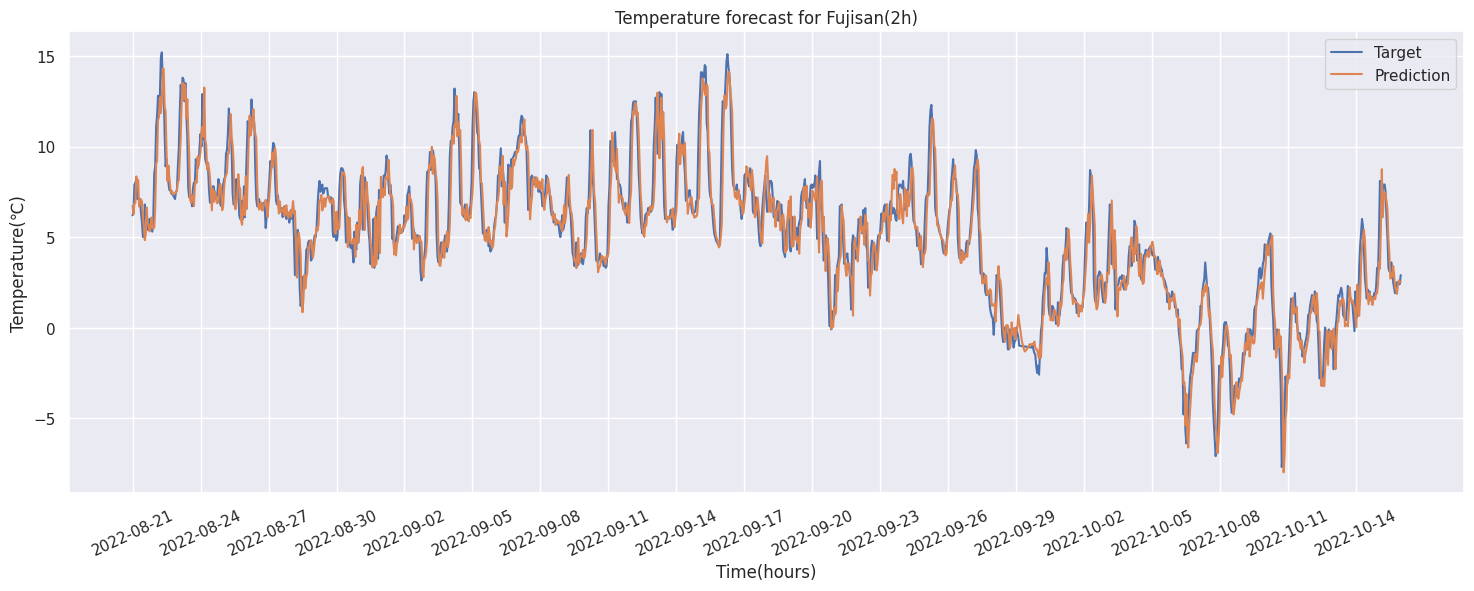

In [8]:
runner_el.run_val(fixed_params, p='f', h=h) # See the validation results

In [9]:
# Train on a tuned model, measure time, and calculate evaluation scores

runner_el.run_train_all(fixed_params)
scores = {}
scores['Elastic net'] = [runner_el.best_score, runner_el.t_train]

### LightGBM

In [10]:
def bayes_objective_lgall(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
            'max_depth': trial.suggest_int('max_depth', 5, 10, step=1)
        }
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_lg = ex.Runner(model.LgbmSL, mf_train_x_all, mf_train_y)
runner_lg.run_opt(bayes_objective_lgall, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 12:27:16,803] A new study created in memory with name: no-name-16ee2435-4439-4182-84eb-d52dbb1f5d6e
[I 2023-08-25 12:27:19,198] Trial 0 finished with value: 1.1158804002519107 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.1158804002519107.
[I 2023-08-25 12:27:23,615] Trial 1 finished with value: 1.2798223387468803 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.1158804002519107.
[I 2023-08-25 12:27:26,103] Trial 2 finished with value: 1.124754388905874 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.1158804002519107.
[I 2023-08-25 12:27:27,962] Trial 3 finished with value: 1.1389527124421257 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, '

best params {'num_leaves': 31, 'colsample_bytree': 0.75, 'subsample': 0.65, 'min_child_samples': 28, 'max_depth': 7}
best score 1.109


[10]	valid_0's rmse: 4.25575	valid_0's l2: 18.1114
[20]	valid_0's rmse: 1.92117	valid_0's l2: 3.69088
[30]	valid_0's rmse: 1.29062	valid_0's l2: 1.6657
[40]	valid_0's rmse: 1.15423	valid_0's l2: 1.33225
[50]	valid_0's rmse: 1.11758	valid_0's l2: 1.24899
[60]	valid_0's rmse: 1.10337	valid_0's l2: 1.21743
[70]	valid_0's rmse: 1.09828	valid_0's l2: 1.20622
[80]	valid_0's rmse: 1.09657	valid_0's l2: 1.20247
[90]	valid_0's rmse: 1.09536	valid_0's l2: 1.19981
[100]	valid_0's rmse: 1.09423	valid_0's l2: 1.19733
[110]	valid_0's rmse: 1.09308	valid_0's l2: 1.19482
[120]	valid_0's rmse: 1.09363	valid_0's l2: 1.19603


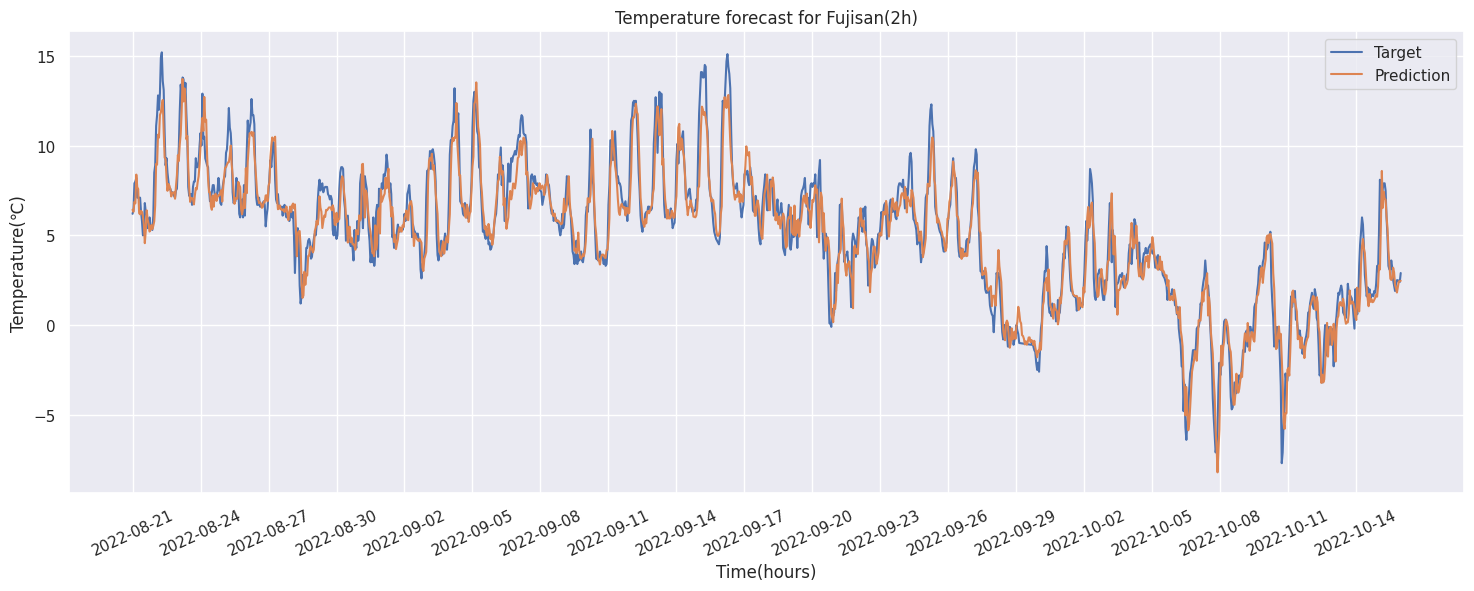

In [11]:
fixed_params = {'patience' : 15,
                'verbose' : 10,
                'n_estimators' : 10000}

runner_lg.run_val(fixed_params, p='f', h=h)

In [12]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_lg.run_train_all(fixed_params)
scores['LightGBM'] = [runner_lg.best_score, runner_lg.t_train]

### XGBoost

In [13]:
def bayes_objective_xgboost(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
            'max_depth': trial.suggest_int('max_depth', 3, 9, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.6, 0.95, step=0.05)}
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_xgboost = ex.Runner(model.Xgboost, mf_train_x_all, mf_train_y)
runner_xgboost.run_opt(bayes_objective_xgboost, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 12:31:40,639] A new study created in memory with name: no-name-f5479ef0-db58-48fc-b91d-903ee5435067


[12:31:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:31:47,898] Trial 0 finished with value: 1.2001128160366135 and parameters: {'min_child_weight': 4, 'max_depth': 9, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 0 with value: 1.2001128160366135.


[12:31:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:31:53,380] Trial 1 finished with value: 1.1590203391894016 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.6, 'subsample': 0.9}. Best is trial 1 with value: 1.1590203391894016.


[12:31:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:31:58,323] Trial 2 finished with value: 1.1644512608543538 and parameters: {'min_child_weight': 7, 'max_depth': 7, 'colsample_bytree': 0.6, 'subsample': 0.95}. Best is trial 1 with value: 1.1590203391894016.


[12:31:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:31:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:02,060] Trial 3 finished with value: 1.152919004481171 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.65, 'subsample': 0.65}. Best is trial 3 with value: 1.152919004481171.


[12:32:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:08,906] Trial 4 finished with value: 1.1607748989796043 and parameters: {'min_child_weight': 4, 'max_depth': 6, 'colsample_bytree': 0.75, 'subsample': 0.7}. Best is trial 3 with value: 1.152919004481171.


[12:32:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:14,355] Trial 5 finished with value: 1.17793230448088 and parameters: {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.7, 'subsample': 0.7}. Best is trial 3 with value: 1.152919004481171.


[12:32:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:21,677] Trial 6 finished with value: 1.1857925820255255 and parameters: {'min_child_weight': 5, 'max_depth': 8, 'colsample_bytree': 0.65, 'subsample': 0.8}. Best is trial 3 with value: 1.152919004481171.


[12:32:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:27,034] Trial 7 finished with value: 1.1758239790706897 and parameters: {'min_child_weight': 6, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample': 0.65}. Best is trial 3 with value: 1.152919004481171.


[12:32:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:36,358] Trial 8 finished with value: 1.1987399730319808 and parameters: {'min_child_weight': 1, 'max_depth': 9, 'colsample_bytree': 0.95, 'subsample': 0.9}. Best is trial 3 with value: 1.152919004481171.


[12:32:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:42,822] Trial 9 finished with value: 1.1676147842527225 and parameters: {'min_child_weight': 4, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.75}. Best is trial 3 with value: 1.152919004481171.


[12:32:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:49,330] Trial 10 finished with value: 1.1400519524507906 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.7, 'subsample': 0.6}. Best is trial 10 with value: 1.1400519524507906.


[12:32:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:32:54,395] Trial 11 finished with value: 1.1400519524507906 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.7, 'subsample': 0.6}. Best is trial 10 with value: 1.1400519524507906.


[12:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:32:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:00,036] Trial 12 finished with value: 1.1436499434658975 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.75, 'subsample': 0.6}. Best is trial 10 with value: 1.1400519524507906.


[12:33:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:05,152] Trial 13 finished with value: 1.155663680269715 and parameters: {'min_child_weight': 9, 'max_depth': 6, 'colsample_bytree': 0.7, 'subsample': 0.6}. Best is trial 10 with value: 1.1400519524507906.


[12:33:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:10,191] Trial 14 finished with value: 1.1400519524507906 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.7, 'subsample': 0.6}. Best is trial 10 with value: 1.1400519524507906.


[12:33:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:17,174] Trial 15 finished with value: 1.1498586169774991 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.7}. Best is trial 10 with value: 1.1400519524507906.


[12:33:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:21,694] Trial 16 finished with value: 1.1679171544753213 and parameters: {'min_child_weight': 10, 'max_depth': 7, 'colsample_bytree': 0.65, 'subsample': 0.65}. Best is trial 10 with value: 1.1400519524507906.


[12:33:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:28,466] Trial 17 finished with value: 1.1390438763988626 and parameters: {'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.95, 'subsample': 0.75}. Best is trial 17 with value: 1.1390438763988626.


[12:33:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:33,114] Trial 18 finished with value: 1.1340061269070947 and parameters: {'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.95, 'subsample': 0.85}. Best is trial 18 with value: 1.1340061269070947.


[12:33:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:37,763] Trial 19 finished with value: 1.1340061269070947 and parameters: {'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.95, 'subsample': 0.85}. Best is trial 18 with value: 1.1340061269070947.


[12:33:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:43,772] Trial 20 finished with value: 1.1318733304550637 and parameters: {'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:33:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:48,504] Trial 21 finished with value: 1.1318733304550637 and parameters: {'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:33:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:54,595] Trial 22 finished with value: 1.1318733304550637 and parameters: {'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:33:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:33:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:33:59,554] Trial 23 finished with value: 1.1723952622527747 and parameters: {'min_child_weight': 5, 'max_depth': 3, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:33:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:06,773] Trial 24 finished with value: 1.137305630847692 and parameters: {'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.9}. Best is trial 20 with value: 1.1318733304550637.


[12:34:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:11,541] Trial 25 finished with value: 1.1415834751816876 and parameters: {'min_child_weight': 6, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 20 with value: 1.1318733304550637.


[12:34:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:18,524] Trial 26 finished with value: 1.1659708651693081 and parameters: {'min_child_weight': 3, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 20 with value: 1.1318733304550637.


[12:34:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:25,180] Trial 27 finished with value: 1.1325396301387929 and parameters: {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:34:25] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:30,356] Trial 28 finished with value: 1.16204361493637 and parameters: {'min_child_weight': 5, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 20 with value: 1.1318733304550637.


[12:34:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:36,392] Trial 29 finished with value: 1.1408610277621074 and parameters: {'min_child_weight': 3, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.8}. Best is trial 20 with value: 1.1318733304550637.


[12:34:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:43,052] Trial 30 finished with value: 1.1741077798956996 and parameters: {'min_child_weight': 6, 'max_depth': 3, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:34:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:49,832] Trial 31 finished with value: 1.1325396301387929 and parameters: {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 20 with value: 1.1318733304550637.


[12:34:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:34:54,345] Trial 32 finished with value: 1.1289465738728062 and parameters: {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:34:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:00,065] Trial 33 finished with value: 1.145651898993271 and parameters: {'min_child_weight': 5, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:35:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:04,593] Trial 34 finished with value: 1.1289465738728062 and parameters: {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:35:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:09,105] Trial 35 finished with value: 1.1479839404865517 and parameters: {'min_child_weight': 7, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:35:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:15,813] Trial 36 finished with value: 1.1639067872624325 and parameters: {'min_child_weight': 9, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:35:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:21,793] Trial 37 finished with value: 1.16265714975054 and parameters: {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:35:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:29,994] Trial 38 finished with value: 1.1629031878054252 and parameters: {'min_child_weight': 4, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:35:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:35,153] Trial 39 finished with value: 1.1521956430356692 and parameters: {'min_child_weight': 7, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:35:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:41,952] Trial 40 finished with value: 1.1387476758179995 and parameters: {'min_child_weight': 5, 'max_depth': 4, 'colsample_bytree': 0.95, 'subsample': 0.8}. Best is trial 32 with value: 1.1289465738728062.


[12:35:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:46,785] Trial 41 finished with value: 1.1318733304550637 and parameters: {'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 32 with value: 1.1289465738728062.


[12:35:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:54,182] Trial 42 finished with value: 1.137305630847692 and parameters: {'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:35:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:35:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:35:58,984] Trial 43 finished with value: 1.1438646898259657 and parameters: {'min_child_weight': 6, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:35:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:05,947] Trial 44 finished with value: 1.1671086026972368 and parameters: {'min_child_weight': 8, 'max_depth': 3, 'colsample_bytree': 0.95, 'subsample': 0.8}. Best is trial 32 with value: 1.1289465738728062.


[12:36:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:12,187] Trial 45 finished with value: 1.1421574268419183 and parameters: {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.75}. Best is trial 32 with value: 1.1289465738728062.


[12:36:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:19,565] Trial 46 finished with value: 1.2051407608320683 and parameters: {'min_child_weight': 5, 'max_depth': 9, 'colsample_bytree': 0.75, 'subsample': 0.85}. Best is trial 32 with value: 1.1289465738728062.


[12:36:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:24,399] Trial 47 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:29,178] Trial 48 finished with value: 1.1334825860277735 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:35,291] Trial 49 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:39,190] Trial 50 finished with value: 1.1423895896251501 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.75, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:43,780] Trial 51 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:49,868] Trial 52 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:36:54,890] Trial 53 finished with value: 1.1460569622195804 and parameters: {'min_child_weight': 9, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:36:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:36:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:00,975] Trial 54 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:06,105] Trial 55 finished with value: 1.154114094590619 and parameters: {'min_child_weight': 10, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:11,911] Trial 56 finished with value: 1.1334825860277735 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:17,030] Trial 57 finished with value: 1.1465216002440812 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:21,921] Trial 58 finished with value: 1.1481768363259721 and parameters: {'min_child_weight': 9, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:25] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:27,165] Trial 59 finished with value: 1.1547370927332896 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.6, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:37:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:31,849] Trial 60 finished with value: 1.1334825860277735 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:36,472] Trial 61 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:43,094] Trial 62 finished with value: 1.154114094590619 and parameters: {'min_child_weight': 10, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:47,912] Trial 63 finished with value: 1.1465216002440812 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:37:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:37:57,030] Trial 64 finished with value: 1.168968365930138 and parameters: {'min_child_weight': 9, 'max_depth': 8, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:37:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:37:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:02,218] Trial 65 finished with value: 1.1403018777964091 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:38:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:08,303] Trial 66 finished with value: 1.1344777767372236 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:13,179] Trial 67 finished with value: 1.1471507368535083 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.75, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:20,099] Trial 68 finished with value: 1.1472487006225995 and parameters: {'min_child_weight': 10, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:38:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:24,756] Trial 69 finished with value: 1.1368741930368191 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:29,953] Trial 70 finished with value: 1.131421240130714 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:38:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:36,065] Trial 71 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:40,760] Trial 72 finished with value: 1.1327644093157876 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:46,727] Trial 73 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:51,888] Trial 74 finished with value: 1.156988508772692 and parameters: {'min_child_weight': 8, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.7}. Best is trial 32 with value: 1.1289465738728062.


[12:38:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:38:56,725] Trial 75 finished with value: 1.1340744146573576 and parameters: {'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:38:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:38:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:02,831] Trial 76 finished with value: 1.1465216002440812 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:08,380] Trial 77 finished with value: 1.1578853100362612 and parameters: {'min_child_weight': 8, 'max_depth': 7, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:13,953] Trial 78 finished with value: 1.132998493351132 and parameters: {'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:39:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:19,680] Trial 79 finished with value: 1.132479361513589 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:26,219] Trial 80 finished with value: 1.1473454492477728 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:30,877] Trial 81 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:35,510] Trial 82 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:41,977] Trial 83 finished with value: 1.1340284514634031 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:46,825] Trial 84 finished with value: 1.1465216002440812 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:39:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:53,204] Trial 85 finished with value: 1.1453573879602794 and parameters: {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:39:57,702] Trial 86 finished with value: 1.1370508508580726 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:39:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:39:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:02,760] Trial 87 finished with value: 1.1454044975528002 and parameters: {'min_child_weight': 9, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:40:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:09,454] Trial 88 finished with value: 1.1410511364858136 and parameters: {'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:14,699] Trial 89 finished with value: 1.1332778492342561 and parameters: {'min_child_weight': 7, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:40:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:21,414] Trial 90 finished with value: 1.134875966806091 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:26,070] Trial 91 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:31,983] Trial 92 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:38,224] Trial 93 finished with value: 1.1434441303345908 and parameters: {'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:42,934] Trial 94 finished with value: 1.129191754224281 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:49,367] Trial 95 finished with value: 1.1340284514634031 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:40:54,569] Trial 96 finished with value: 1.1410511364858136 and parameters: {'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


[12:40:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:40:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:41:00,910] Trial 97 finished with value: 1.1466396901703588 and parameters: {'min_child_weight': 10, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.75}. Best is trial 32 with value: 1.1289465738728062.


[12:41:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:41:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:41:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:41:05,717] Trial 98 finished with value: 1.1465216002440812 and parameters: {'min_child_weight': 9, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 32 with value: 1.1289465738728062.


[12:41:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:41:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:41:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:41:13,540] Trial 99 finished with value: 1.129347225583696 and parameters: {'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.95}. Best is trial 32 with value: 1.1289465738728062.


best params {'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.9}
best score 1.129


[12:41:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[0]	validation_0-rmse:4.39313
[20]	validation_0-rmse:1.13937
[40]	validation_0-rmse:1.12645
[50]	validation_0-rmse:1.13153


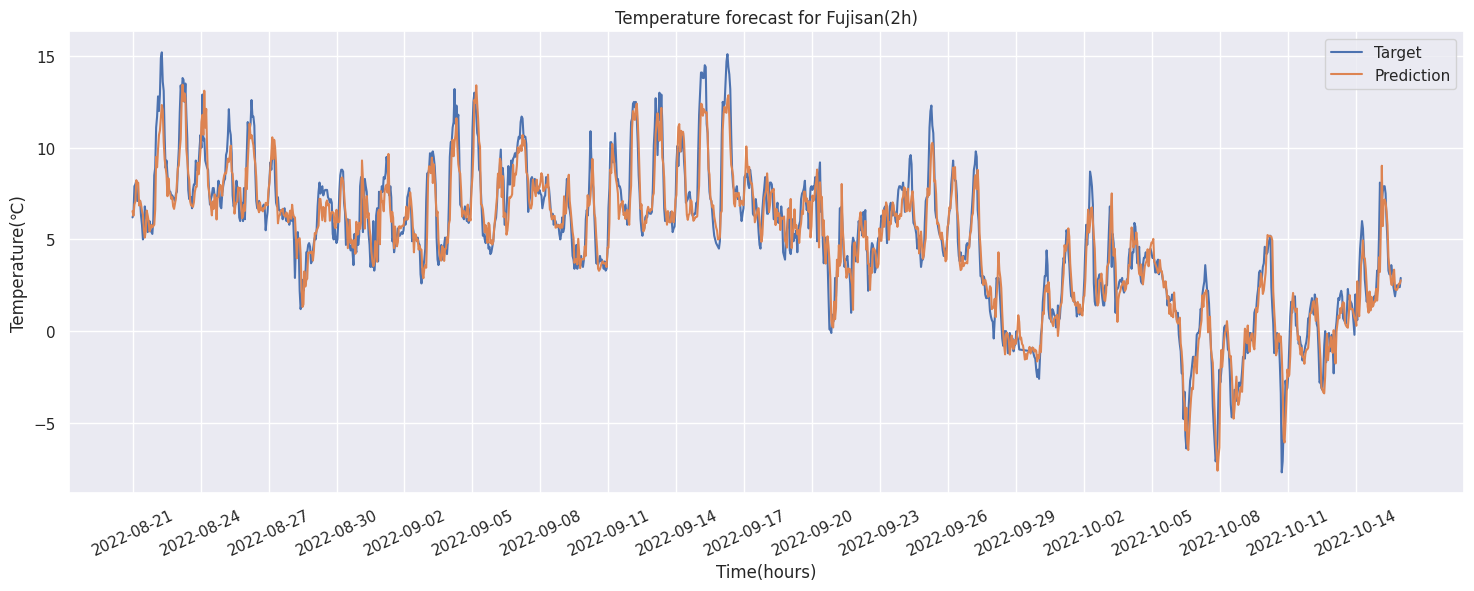

In [14]:
fixed_params = {'patience' : 15,
                'verbose' : 20,
                'n_estimators' : 10000}

runner_xgboost.run_val(fixed_params, p='f', h=h)

In [15]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_xgboost.run_train_all(fixed_params)
scores['XGBoost'] = [runner_xgboost.best_score, runner_xgboost.t_train]

[12:41:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



### ExtraTreesRegressor(Random Forest)

In [16]:
params = {
    'n_estimators': 100
}

fixed_params = {}
runner_et = ex.Runner(model.ExtraTrees, mf_train_x_all, mf_train_y)
runner_et.hand_opt(params, fixed_params, round_num=3)

params {'n_estimators': 100}
score 1.14


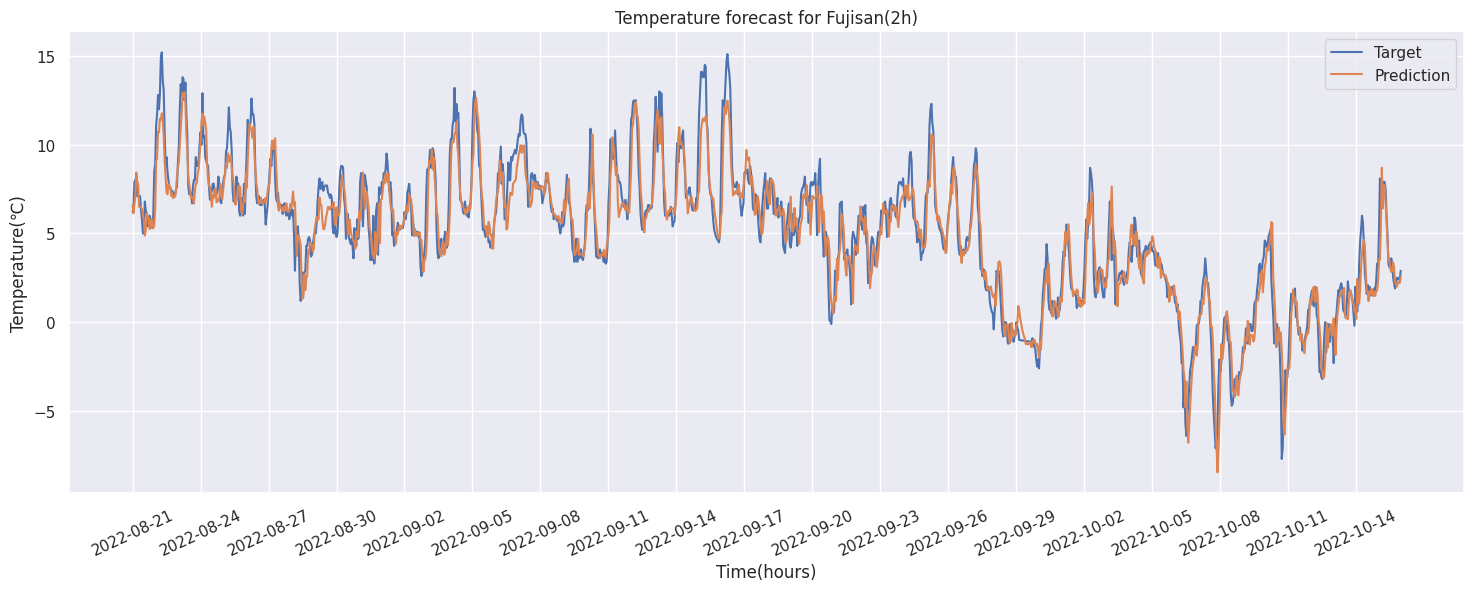

In [17]:
runner_et.run_val(fixed_params, p='f', h=h)

In [18]:
runner_et.run_train_all(fixed_params)
scores['Extra trees'] = [runner_et.score, runner_et.t_train]

### Neural Network

In [19]:
params = {
    'hidden_units1': 1000,
    'hidden_units2': 1000,
    'hidden_units3': 100,
    'hidden_dropout': 0.2
}

fixed_params = {'patience' : 15,
                'verbose' : 1,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}

tf.random.set_seed(42)
runner_nn = ex.Runner(model.MLP, mf_train_x_all, mf_train_y)
runner_nn.hand_opt(params, fixed_params, round_num=3)

Epoch 1/100
314/314 [==============================] - 7s 4ms/step - loss: 8.6674 - rmse: 2.9440 - val_loss: 4.0585 - val_rmse: 2.0146
Epoch 2/100
314/314 [==============================] - 1s 3ms/step - loss: 3.9643 - rmse: 1.9911 - val_loss: 2.4954 - val_rmse: 1.5797
Epoch 3/100
314/314 [==============================] - 1s 3ms/step - loss: 3.3341 - rmse: 1.8259 - val_loss: 1.8776 - val_rmse: 1.3703
Epoch 4/100
314/314 [==============================] - 1s 3ms/step - loss: 3.0647 - rmse: 1.7506 - val_loss: 2.0604 - val_rmse: 1.4354
Epoch 5/100
314/314 [==============================] - 1s 3ms/step - loss: 2.8521 - rmse: 1.6888 - val_loss: 1.5100 - val_rmse: 1.2288
Epoch 6/100
314/314 [==============================] - 1s 3ms/step - loss: 2.7454 - rmse: 1.6569 - val_loss: 2.5588 - val_rmse: 1.5996
Epoch 7/100
314/314 [==============================] - 1s 3ms/step - loss: 2.6268 - rmse: 1.6207 - val_loss: 1.4658 - val_rmse: 1.2107
Epoch 8/100
314/314 [==============================] - 

Epoch 1/100
405/405 [==============================] - 2s 3ms/step - loss: 7.9920 - rmse: 2.8270 - val_loss: 3.1768 - val_rmse: 1.7824
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 3.7958 - rmse: 1.9483 - val_loss: 2.3726 - val_rmse: 1.5403
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 3.2882 - rmse: 1.8133 - val_loss: 2.1271 - val_rmse: 1.4585
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 3.0360 - rmse: 1.7424 - val_loss: 2.0081 - val_rmse: 1.4171
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8937 - rmse: 1.7011 - val_loss: 1.8368 - val_rmse: 1.3553
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 2.7830 - rmse: 1.6682 - val_loss: 1.7097 - val_rmse: 1.3076
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 2.6296 - rmse: 1.6216 - val_loss: 1.7158 - val_rmse: 1.3099
Epoch 8/100
405/405 [==============================] - 

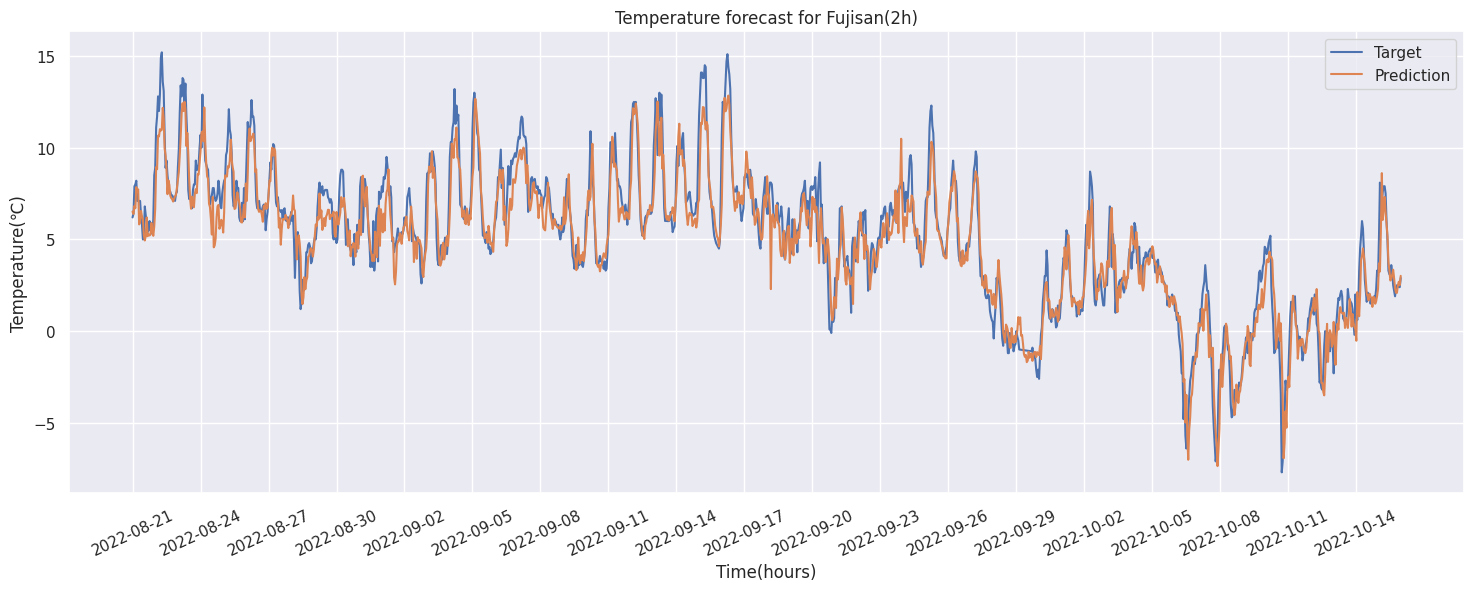

In [20]:
fixed_params = {'patience' : 15,
                'verbose' : 1,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}

runner_nn.run_val(fixed_params, p='f', h=h)

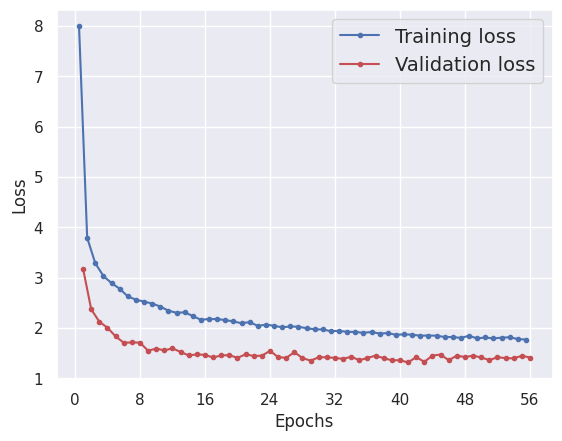

In [21]:
runner_nn.run_curve()

In [22]:
fixed_params = {'patience' : False,
                'verbose' : 0,
                'learning_rate' : 0.001,
                'nb_epoch' : True}

runner_nn.run_train_all(fixed_params)
scores['Neural network'] = [runner_nn.score, runner_nn.t_train]

### Model Comparison

,Elastic net,LightGBM,XGBoost,Extra trees,Neural network
RMSE,1.178,1.109,1.129,1.140,1.192
Training time(s),1.597,1.814,1.262,15.885,60.986


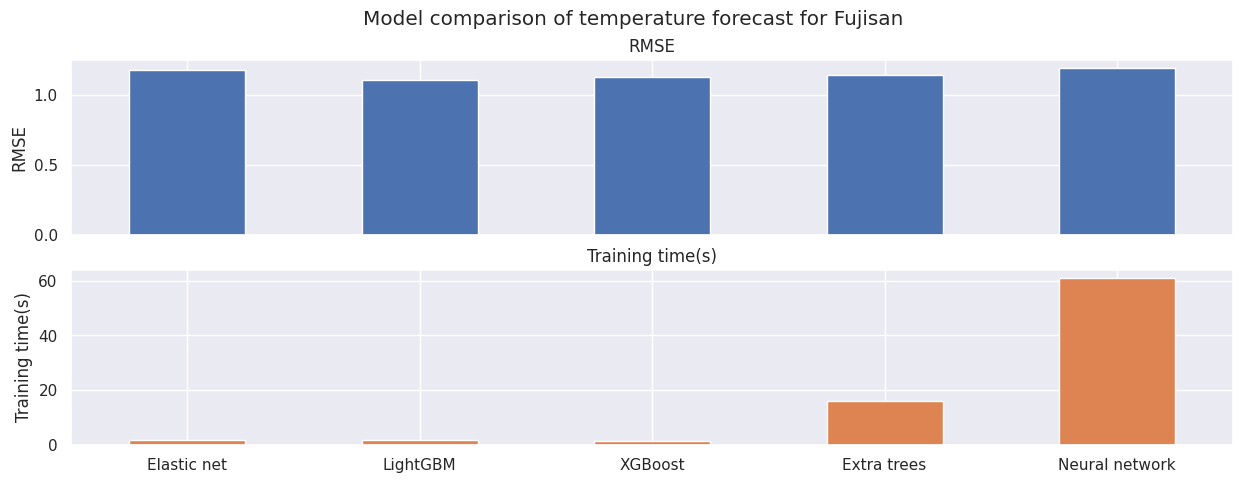

In [23]:
# Compare the accuracy of the model on the validation data

df_rmse = ex.val_rmse(scores, title='Model comparison of temperature forecast for Fujisan')
df_rmse

## Precipitation prediction for Hakone

In [24]:
h_train_x_all, h_train_y = md.make_exp_dataset(dataset,md.get_data_hk_2h)
h='(2h)'

'''
h_train_x_all, h_train_y = md.make_exp_dataset(dataset,md.get_data_hk_8h)
h='(8h)'
'''

"\nh_train_x_all, h_train_y = md.make_exp_dataset(dataset,md.get_data_hk_8h)\nh='(8h)'\n"

### Elastic(linear)

In [25]:
def bayes_objective_el(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'alpha': trial.suggest_float('alpha', 0.0, 1.0, step=0.01),
            'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0, step=0.01),
            'max_iter': trial.suggest_int('max_iter', 100, 1000, step=50)
        }
        val = ex.get_scores(Model=Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params=params)
        return val

    return objective

fixed_params = {'seed' : 42}
runner_el = ex.Runner(model.Elastic, h_train_x_all, h_train_y)
runner_el.run_opt(bayes_objective_el, fixed_params=fixed_params, n_trials=100, seed = 42)

[I 2023-08-25 12:47:43,152] A new study created in memory with name: no-name-65eb9ed9-39f2-4934-8056-b4a0ad06ee97
[I 2023-08-25 12:47:43,562] Trial 0 finished with value: 1.0660657722011038 and parameters: {'alpha': 0.37, 'l1_ratio': 0.96, 'max_iter': 750}. Best is trial 0 with value: 1.0660657722011038.
[I 2023-08-25 12:47:44,103] Trial 1 finished with value: 1.0831897453150694 and parameters: {'alpha': 0.6, 'l1_ratio': 0.15, 'max_iter': 200}. Best is trial 0 with value: 1.0660657722011038.
[I 2023-08-25 12:47:44,584] Trial 2 finished with value: 1.1085748926953343 and parameters: {'alpha': 0.05, 'l1_ratio': 0.87, 'max_iter': 650}. Best is trial 0 with value: 1.0660657722011038.
[I 2023-08-25 12:47:45,126] Trial 3 finished with value: 1.0925290750037964 and parameters: {'alpha': 0.71, 'l1_ratio': 0.02, 'max_iter': 1000}. Best is trial 0 with value: 1.0660657722011038.
[I 2023-08-25 12:47:45,545] Trial 4 finished with value: 1.083009572159507 and parameters: {'alpha': 0.84, 'l1_ratio':

best params {'alpha': 0.47000000000000003, 'l1_ratio': 0.91, 'max_iter': 900}
best score 1.063


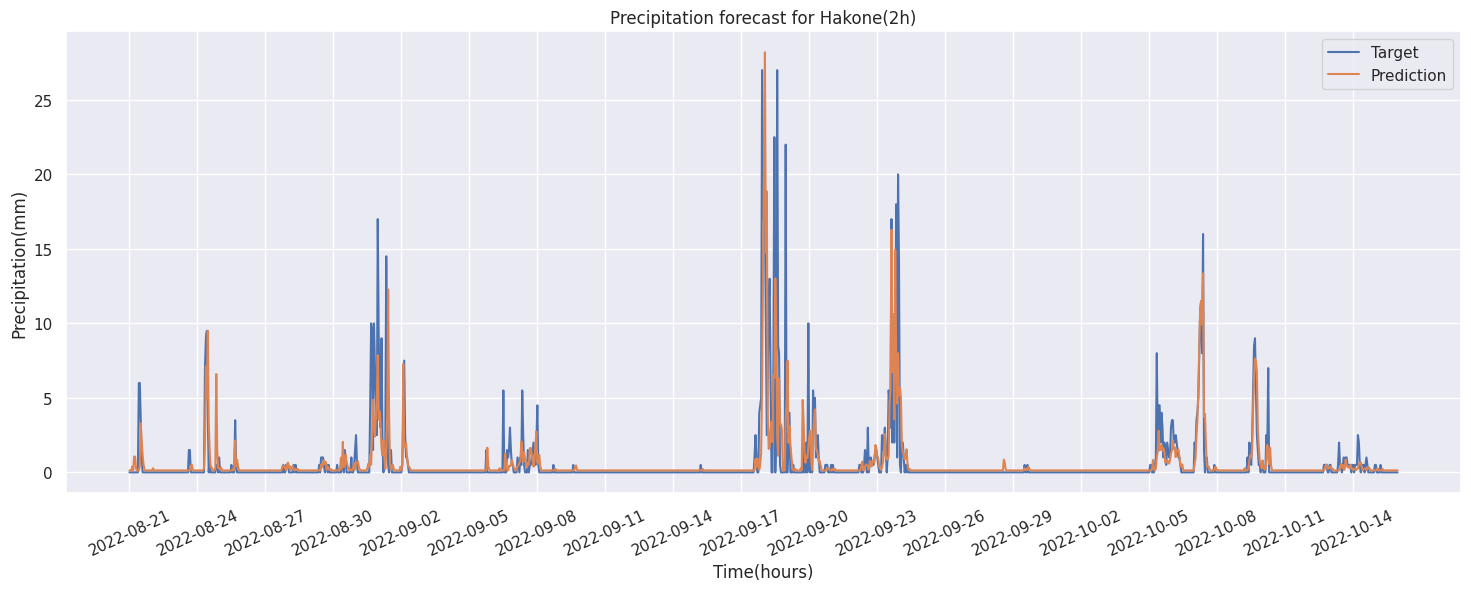

In [26]:
runner_el.run_val(fixed_params, p='h', h=h)

In [27]:
runner_el.run_train_all(fixed_params)
scores = {}
scores['Elastic net'] = [runner_el.best_score, runner_el.t_train]

### LightGBM

In [28]:
def bayes_objective_lgall(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
            'max_depth': trial.suggest_int('max_depth', 5, 10, step=1)
        }
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_lg = ex.Runner(model.LgbmSL, h_train_x_all, h_train_y)
runner_lg.run_opt(bayes_objective_lgall, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 12:48:35,146] A new study created in memory with name: no-name-b2cad727-0fea-432b-9e20-bfb64ae9ef31
[I 2023-08-25 12:48:36,090] Trial 0 finished with value: 0.9809944111828287 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 0.9809944111828287.
[I 2023-08-25 12:48:36,831] Trial 1 finished with value: 1.1064027753608878 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 0.9809944111828287.
[I 2023-08-25 12:48:37,707] Trial 2 finished with value: 0.9896759844599435 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 0.9809944111828287.
[I 2023-08-25 12:48:38,658] Trial 3 finished with value: 1.009629097071733 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, '

best params {'num_leaves': 7, 'colsample_bytree': 0.75, 'subsample': 0.6, 'min_child_samples': 23, 'max_depth': 10}
best score 0.951


[10]	valid_0's rmse: 1.7611	valid_0's l2: 3.10149
[20]	valid_0's rmse: 1.62046	valid_0's l2: 2.62588
[30]	valid_0's rmse: 1.6097	valid_0's l2: 2.59114
[40]	valid_0's rmse: 1.6246	valid_0's l2: 2.63933


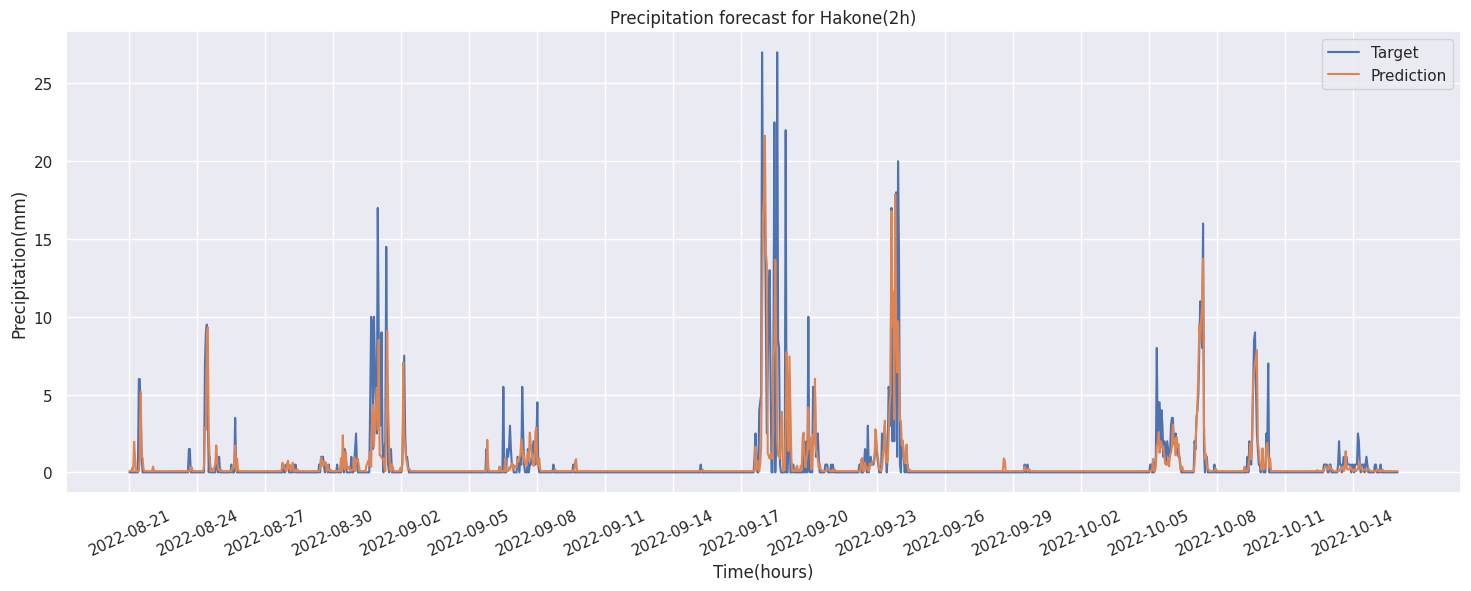

In [29]:
fixed_params = {'patience' : 15,
                'verbose' : 10,
                'n_estimators' : 10000}

runner_lg.run_val(fixed_params, p='h', h=h)

In [30]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_lg.run_train_all(fixed_params)
scores['LightGBM'] = [runner_lg.best_score, runner_lg.t_train]

### XGBoost

In [31]:
def bayes_objective_xgboost(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
            'max_depth': trial.suggest_int('max_depth', 3, 9, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.6, 0.95, step=0.05)}
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_xgboost = ex.Runner(model.Xgboost, h_train_x_all, h_train_y)
runner_xgboost.run_opt(bayes_objective_xgboost, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 12:50:17,960] A new study created in memory with name: no-name-f337e113-1f03-4ffa-9a79-b3151b6f1848


[12:50:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:24,265] Trial 0 finished with value: 1.0104064385147784 and parameters: {'min_child_weight': 4, 'max_depth': 9, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 0 with value: 1.0104064385147784.


[12:50:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:25] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:26,206] Trial 1 finished with value: 1.0141049169015437 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.6, 'subsample': 0.9}. Best is trial 0 with value: 1.0104064385147784.


[12:50:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:29,333] Trial 2 finished with value: 1.0215727037395619 and parameters: {'min_child_weight': 7, 'max_depth': 7, 'colsample_bytree': 0.6, 'subsample': 0.95}. Best is trial 0 with value: 1.0104064385147784.


[12:50:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:31,284] Trial 3 finished with value: 1.0477418418162092 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.65, 'subsample': 0.65}. Best is trial 0 with value: 1.0104064385147784.


[12:50:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:34,487] Trial 4 finished with value: 1.018147712174307 and parameters: {'min_child_weight': 4, 'max_depth': 6, 'colsample_bytree': 0.75, 'subsample': 0.7}. Best is trial 0 with value: 1.0104064385147784.


[12:50:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:37,917] Trial 5 finished with value: 1.0006623580892302 and parameters: {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.7, 'subsample': 0.7}. Best is trial 5 with value: 1.0006623580892302.


[12:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:41,193] Trial 6 finished with value: 1.029237779291491 and parameters: {'min_child_weight': 5, 'max_depth': 8, 'colsample_bytree': 0.65, 'subsample': 0.8}. Best is trial 5 with value: 1.0006623580892302.


[12:50:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:43,057] Trial 7 finished with value: 1.0339147110880444 and parameters: {'min_child_weight': 6, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample': 0.65}. Best is trial 5 with value: 1.0006623580892302.


[12:50:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:47,782] Trial 8 finished with value: 1.0201280598978544 and parameters: {'min_child_weight': 1, 'max_depth': 9, 'colsample_bytree': 0.95, 'subsample': 0.9}. Best is trial 5 with value: 1.0006623580892302.


[12:50:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:51,389] Trial 9 finished with value: 1.0077093566465865 and parameters: {'min_child_weight': 4, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.75}. Best is trial 5 with value: 1.0006623580892302.


[12:50:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:53,760] Trial 10 finished with value: 1.0355564934775032 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.7, 'subsample': 0.6}. Best is trial 5 with value: 1.0006623580892302.


[12:50:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:56,022] Trial 11 finished with value: 1.0005927198187052 and parameters: {'min_child_weight': 8, 'max_depth': 3, 'colsample_bytree': 0.9, 'subsample': 0.75}. Best is trial 11 with value: 1.0005927198187052.


[12:50:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:50:59,002] Trial 12 finished with value: 1.0321926709963725 and parameters: {'min_child_weight': 8, 'max_depth': 5, 'colsample_bytree': 0.95, 'subsample': 0.75}. Best is trial 11 with value: 1.0005927198187052.


[12:50:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:50:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:01,250] Trial 13 finished with value: 0.988065623806165 and parameters: {'min_child_weight': 8, 'max_depth': 3, 'colsample_bytree': 0.9, 'subsample': 0.7}. Best is trial 13 with value: 0.988065623806165.


[12:51:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:05,100] Trial 14 finished with value: 0.9969961311417385 and parameters: {'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 13 with value: 0.988065623806165.


[12:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:07,712] Trial 15 finished with value: 0.9990594532601866 and parameters: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 13 with value: 0.988065623806165.


[12:51:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:10,267] Trial 16 finished with value: 0.990883044248255 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 13 with value: 0.988065623806165.


[12:51:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:14,488] Trial 17 finished with value: 1.021456223239043 and parameters: {'min_child_weight': 8, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.85}. Best is trial 13 with value: 0.988065623806165.


[12:51:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:18,679] Trial 18 finished with value: 0.9998769672795472 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.7}. Best is trial 13 with value: 0.988065623806165.


[12:51:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:20,891] Trial 19 finished with value: 1.0073129833556476 and parameters: {'min_child_weight': 6, 'max_depth': 5, 'colsample_bytree': 0.75, 'subsample': 0.95}. Best is trial 13 with value: 0.988065623806165.


[12:51:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:23,986] Trial 20 finished with value: 1.0376929581766223 and parameters: {'min_child_weight': 9, 'max_depth': 6, 'colsample_bytree': 0.95, 'subsample': 0.8}. Best is trial 13 with value: 0.988065623806165.


[12:51:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:25] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:26,437] Trial 21 finished with value: 0.9969961311417385 and parameters: {'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 13 with value: 0.988065623806165.


[12:51:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:30,008] Trial 22 finished with value: 1.0131562041247635 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.9}. Best is trial 13 with value: 0.988065623806165.


[12:51:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:32,246] Trial 23 finished with value: 0.9922798656311853 and parameters: {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 13 with value: 0.988065623806165.


[12:51:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:34,204] Trial 24 finished with value: 0.9686186106617826 and parameters: {'min_child_weight': 8, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 24 with value: 0.9686186106617826.


[12:51:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:36,256] Trial 25 finished with value: 1.0163700929618174 and parameters: {'min_child_weight': 8, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample': 0.65}. Best is trial 24 with value: 0.9686186106617826.


[12:51:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:38,501] Trial 26 finished with value: 0.9567935080238318 and parameters: {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 26 with value: 0.9567935080238318.


[12:51:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:42,014] Trial 27 finished with value: 0.9864431800092159 and parameters: {'min_child_weight': 6, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample': 0.75}. Best is trial 26 with value: 0.9567935080238318.


[12:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:45,321] Trial 28 finished with value: 1.0165034250990987 and parameters: {'min_child_weight': 5, 'max_depth': 7, 'colsample_bytree': 0.75, 'subsample': 0.8}. Best is trial 26 with value: 0.9567935080238318.


[12:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:47,530] Trial 29 finished with value: 0.9864431800092159 and parameters: {'min_child_weight': 6, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample': 0.75}. Best is trial 26 with value: 0.9567935080238318.


[12:51:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:50,096] Trial 30 finished with value: 0.9809931650361187 and parameters: {'min_child_weight': 3, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 26 with value: 0.9567935080238318.


[12:51:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:52,819] Trial 31 finished with value: 0.953683527783037 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:51:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:51:56,993] Trial 32 finished with value: 0.953683527783037 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:51:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:00,387] Trial 33 finished with value: 0.9901907985433113 and parameters: {'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:03,035] Trial 34 finished with value: 0.953683527783037 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:06,932] Trial 35 finished with value: 1.0322681059438912 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:10,586] Trial 36 finished with value: 1.0189254564510295 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 31 with value: 0.953683527783037.


[12:52:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:13,310] Trial 37 finished with value: 1.0136960662003096 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.75, 'subsample': 0.75}. Best is trial 31 with value: 0.953683527783037.


[12:52:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:16,899] Trial 38 finished with value: 0.9635304404536781 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:19,260] Trial 39 finished with value: 1.015143002987098 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.85}. Best is trial 31 with value: 0.953683527783037.


[12:52:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:23,600] Trial 40 finished with value: 1.0220241854985685 and parameters: {'min_child_weight': 2, 'max_depth': 7, 'colsample_bytree': 0.7, 'subsample': 0.9}. Best is trial 31 with value: 0.953683527783037.


[12:52:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:25] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:27,233] Trial 41 finished with value: 0.9635304404536781 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:30,401] Trial 42 finished with value: 1.0122677553854407 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.95, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:35,832] Trial 43 finished with value: 1.0547701624575165 and parameters: {'min_child_weight': 4, 'max_depth': 8, 'colsample_bytree': 0.85, 'subsample': 0.75}. Best is trial 31 with value: 0.953683527783037.


[12:52:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:39,592] Trial 44 finished with value: 0.9618497432630292 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:42,274] Trial 45 finished with value: 1.0191934329177792 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.6, 'subsample': 0.75}. Best is trial 31 with value: 0.953683527783037.


[12:52:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:44,386] Trial 46 finished with value: 0.993757661772352 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 31 with value: 0.953683527783037.


[12:52:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:47,223] Trial 47 finished with value: 1.0601669191639171 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.95, 'subsample': 0.7}. Best is trial 31 with value: 0.953683527783037.


[12:52:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:51,499] Trial 48 finished with value: 0.9693814578410862 and parameters: {'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:54,037] Trial 49 finished with value: 1.014376547954778 and parameters: {'min_child_weight': 5, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.75}. Best is trial 31 with value: 0.953683527783037.


[12:52:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:56,729] Trial 50 finished with value: 1.0072009769896526 and parameters: {'min_child_weight': 7, 'max_depth': 5, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 31 with value: 0.953683527783037.


[12:52:56] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:52:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:52:59,810] Trial 51 finished with value: 0.9590336236678382 and parameters: {'min_child_weight': 1, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:52:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:05,527] Trial 52 finished with value: 1.0003871973986975 and parameters: {'min_child_weight': 1, 'max_depth': 8, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:53:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:09,633] Trial 53 finished with value: 1.0197807971327253 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.95, 'subsample': 0.8}. Best is trial 31 with value: 0.953683527783037.


[12:53:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:12,055] Trial 54 finished with value: 1.0314733254523125 and parameters: {'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.75}. Best is trial 31 with value: 0.953683527783037.


[12:53:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:15,940] Trial 55 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 31 with value: 0.953683527783037.


[12:53:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:19,435] Trial 56 finished with value: 0.9318199176932468 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:22,562] Trial 57 finished with value: 1.0176265012905221 and parameters: {'min_child_weight': 4, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:53:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:26,508] Trial 58 finished with value: 1.0252250531855938 and parameters: {'min_child_weight': 3, 'max_depth': 7, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 56 with value: 0.9318199176932468.


[12:53:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:31,752] Trial 59 finished with value: 1.0450540785905251 and parameters: {'min_child_weight': 2, 'max_depth': 9, 'colsample_bytree': 0.65, 'subsample': 0.95}. Best is trial 56 with value: 0.9318199176932468.


[12:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:34,953] Trial 60 finished with value: 1.0148366966195688 and parameters: {'min_child_weight': 4, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.6}. Best is trial 56 with value: 0.9318199176932468.


[12:53:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:37,679] Trial 61 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:53:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:39,817] Trial 62 finished with value: 0.993757661772352 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:53:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:43,522] Trial 63 finished with value: 0.9848784435134151 and parameters: {'min_child_weight': 3, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:53:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:46,589] Trial 64 finished with value: 0.9619472715375812 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 56 with value: 0.9318199176932468.


[12:53:46] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:49,543] Trial 65 finished with value: 0.9928275784186594 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.95, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:53:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:50] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:52,792] Trial 66 finished with value: 0.9318199176932468 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:53:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:53:57,491] Trial 67 finished with value: 1.0025189961177225 and parameters: {'min_child_weight': 7, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:53:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:53:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:01,006] Trial 68 finished with value: 1.0326346994861073 and parameters: {'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:04,116] Trial 69 finished with value: 0.9676879585802229 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:54:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:09,385] Trial 70 finished with value: 1.0322681059438912 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:54:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:10] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:12,164] Trial 71 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:13] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:15,416] Trial 72 finished with value: 0.9318199176932468 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:17] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:18,443] Trial 73 finished with value: 0.997035236194954 and parameters: {'min_child_weight': 1, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 56 with value: 0.9318199176932468.


[12:54:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:22,715] Trial 74 finished with value: 0.9715717293295384 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:25,985] Trial 75 finished with value: 0.9958163760073173 and parameters: {'min_child_weight': 2, 'max_depth': 7, 'colsample_bytree': 0.75, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:54:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:27] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:29,249] Trial 76 finished with value: 0.9939478157490927 and parameters: {'min_child_weight': 1, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.75}. Best is trial 56 with value: 0.9318199176932468.


[12:54:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:30] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:32,698] Trial 77 finished with value: 0.9594098790863148 and parameters: {'min_child_weight': 3, 'max_depth': 7, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:38,238] Trial 78 finished with value: 0.9745076116724126 and parameters: {'min_child_weight': 4, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:54:38] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:40,505] Trial 79 finished with value: 0.9726113611284584 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.9}. Best is trial 56 with value: 0.9318199176932468.


[12:54:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:42] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:44,268] Trial 80 finished with value: 0.9953443314215346 and parameters: {'min_child_weight': 1, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:54:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:46,926] Trial 81 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:49] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:50,938] Trial 82 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:51] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:52] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:53,619] Trial 83 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:54:53] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:54] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:55] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:54:57,162] Trial 84 finished with value: 0.9667245279115863 and parameters: {'min_child_weight': 3, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:54:57] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:58] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:01,386] Trial 85 finished with value: 0.9612778441098335 and parameters: {'min_child_weight': 5, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:01] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:02] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:03] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:04,424] Trial 86 finished with value: 0.9816248210643522 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.9}. Best is trial 56 with value: 0.9318199176932468.


[12:55:04] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:05] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:06] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:07,755] Trial 87 finished with value: 1.005329378124783 and parameters: {'min_child_weight': 6, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.75}. Best is trial 56 with value: 0.9318199176932468.


[12:55:07] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:08] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:10,936] Trial 88 finished with value: 1.0060558940211577 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:55:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:11] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:12] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:15,109] Trial 89 finished with value: 0.9682698719302175 and parameters: {'min_child_weight': 3, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:15] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:16] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:18,139] Trial 90 finished with value: 0.9693814578410862 and parameters: {'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:55:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:18] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:19] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:20,771] Trial 91 finished with value: 1.0107190679480837 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.95, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:20] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:21] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:23,468] Trial 92 finished with value: 0.9591214649335392 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:24] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:26,097] Trial 93 finished with value: 0.9905522696034827 and parameters: {'min_child_weight': 2, 'max_depth': 5, 'colsample_bytree': 0.9, 'subsample': 0.9}. Best is trial 56 with value: 0.9318199176932468.


[12:55:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:28] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:29] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:31,507] Trial 94 finished with value: 0.9673638402259771 and parameters: {'min_child_weight': 2, 'max_depth': 8, 'colsample_bytree': 0.9, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:32] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:33,224] Trial 95 finished with value: 1.0186466372713614 and parameters: {'min_child_weight': 3, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:55:33] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:35] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:35,993] Trial 96 finished with value: 0.9900325166820032 and parameters: {'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.95, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:37] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:39,035] Trial 97 finished with value: 0.9847855245915073 and parameters: {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


[12:55:39] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:40] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:41] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:43,261] Trial 98 finished with value: 0.9387193093311224 and parameters: {'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.85, 'subsample': 0.85}. Best is trial 56 with value: 0.9318199176932468.


[12:55:43] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[12:55:44] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



[I 2023-08-25 12:55:45,466] Trial 99 finished with value: 0.9567935080238318 and parameters: {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 56 with value: 0.9318199176932468.


best params {'min_child_weight': 2, 'max_depth': 6, 'colsample_bytree': 0.85, 'subsample': 0.85}
best score 0.932


[12:55:45] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.

[0]	validation_0-rmse:2.11061
[20]	validation_0-rmse:1.62712
[28]	validation_0-rmse:1.64162


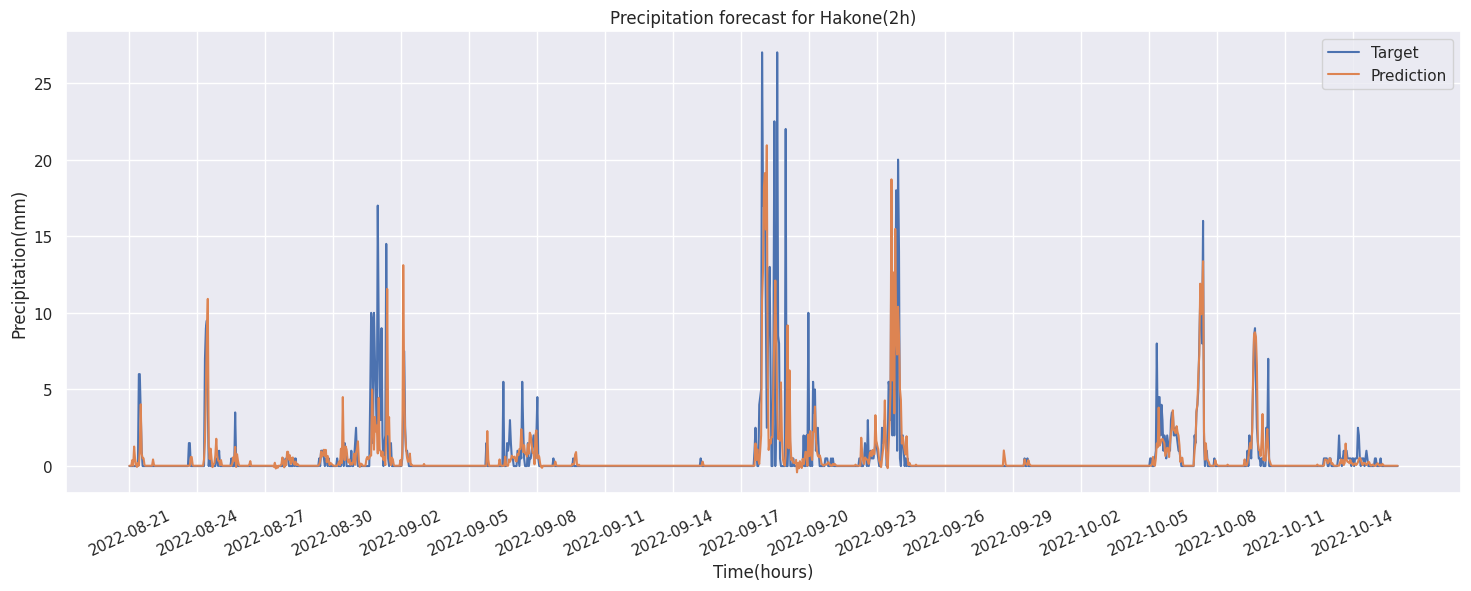

In [32]:
fixed_params = {'patience' : 15,
                'verbose' : 20,
                'n_estimators' : 10000}

runner_xgboost.run_val(fixed_params, p='h', h=h)

In [33]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_xgboost.run_train_all(fixed_params)
scores['XGBoost'] = [runner_xgboost.best_score, runner_xgboost.t_train]

[12:55:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_late" } are not used.



### ExtraTreesRegressor(Random Forest)

In [34]:
params = {
    'n_estimators': 100
}

fixed_params = {}
runner_et = ex.Runner(model.ExtraTrees, h_train_x_all, h_train_y)
runner_et.hand_opt(params, fixed_params, round_num=3)

params {'n_estimators': 100}
score 1.024


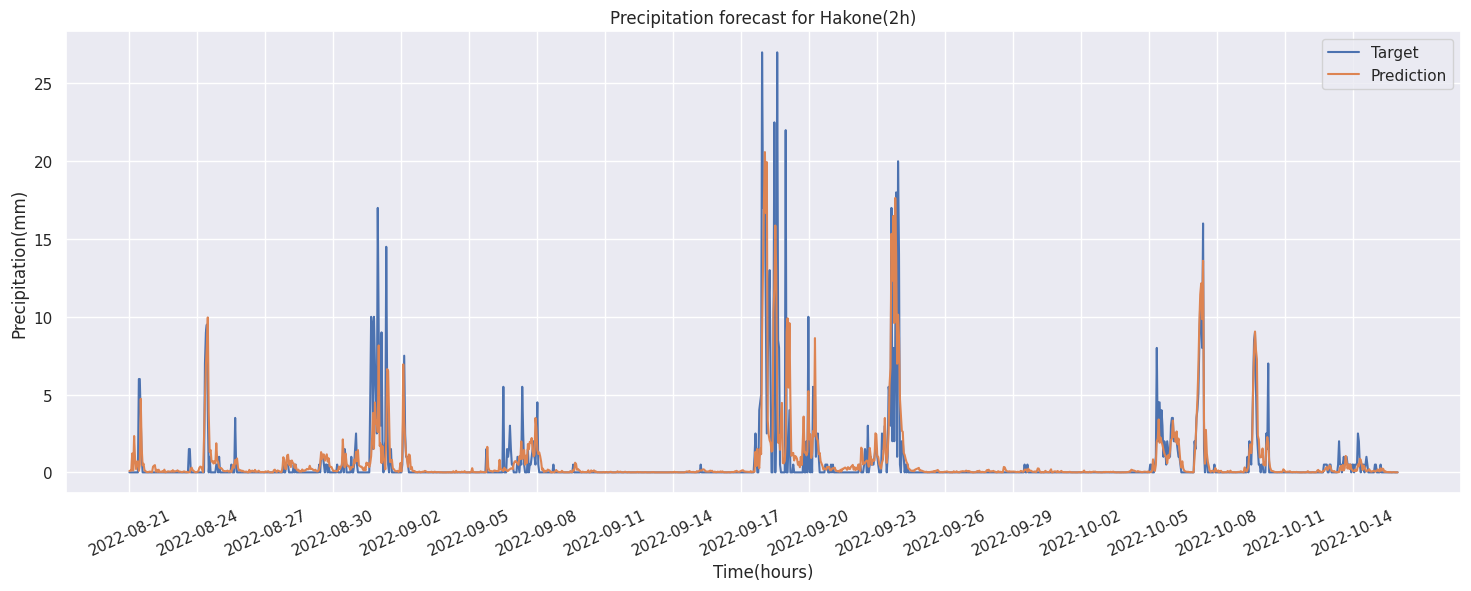

In [35]:
runner_et.run_val(fixed_params, p='h', h=h)

In [36]:
runner_et.run_train_all(fixed_params)
scores['Extra trees'] = [runner_et.score, runner_et.t_train]

### Neural Network

In [37]:
params = {
    'hidden_units1': 1000,
    'hidden_units2': 1000,
    'hidden_units3': 100,
    'hidden_dropout': 0.2
}

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}

tf.random.set_seed(42)
runner_nn = ex.Runner(model.MLP, h_train_x_all, h_train_y)
runner_nn.hand_opt(params, fixed_params, round_num=3)

92/92 [==============================] - 0s 1ms/step
params {'hidden_units1': 1000, 'hidden_units2': 1000, 'hidden_units3': 100, 'hidden_dropout': 0.2}
score 1.019


Epoch 1/100
405/405 [==============================] - 2s 3ms/step - loss: 2.9710 - rmse: 1.7237 - val_loss: 3.4743 - val_rmse: 1.8640
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 2.0958 - rmse: 1.4477 - val_loss: 3.2536 - val_rmse: 1.8038
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 1.8507 - rmse: 1.3604 - val_loss: 3.3860 - val_rmse: 1.8401
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 1.7677 - rmse: 1.3296 - val_loss: 3.3477 - val_rmse: 1.8297
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 1.5906 - rmse: 1.2612 - val_loss: 3.3246 - val_rmse: 1.8234
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6507 - rmse: 1.2848 - val_loss: 3.7194 - val_rmse: 1.9286
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 1.7102 - rmse: 1.3078 - val_loss: 3.4131 - val_rmse: 1.8475
Epoch 8/100
405/405 [==============================] - 

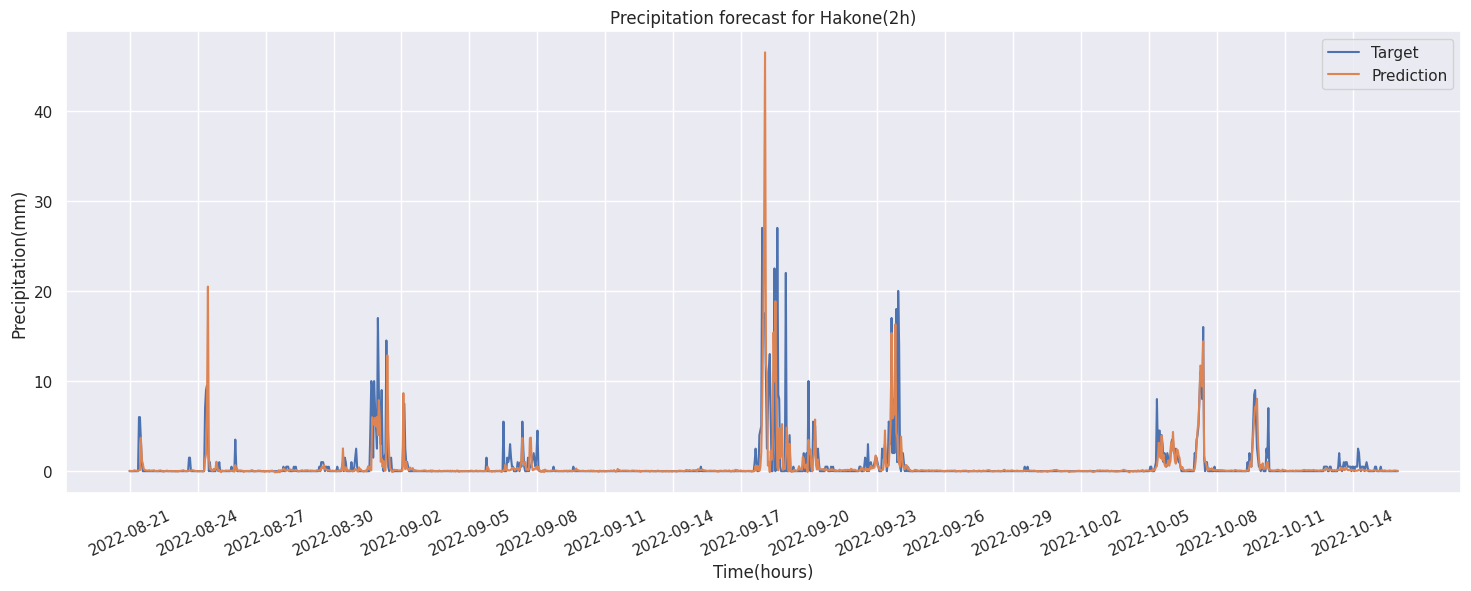

In [38]:
fixed_params = {'patience' : 15,
                'verbose' : 1,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}


runner_nn.run_val(fixed_params, p='h', h=h)

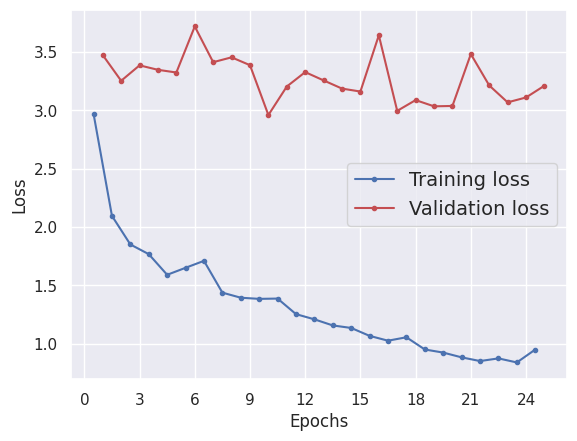

In [39]:
runner_nn.run_curve()

In [40]:
fixed_params = {'patience' : False,
                'verbose' : 0,
                'learning_rate' : 0.001,
                'nb_epoch' : True}

runner_nn.run_train_all(fixed_params)
scores['Neural network'] = [runner_nn.score, runner_nn.t_train]

### Model Comparison

,Elastic net,LightGBM,XGBoost,Extra trees,Neural network
RMSE,1.063,0.951,0.932,1.024,1.019
Training time(s),0.121,0.289,0.737,14.493,27.798


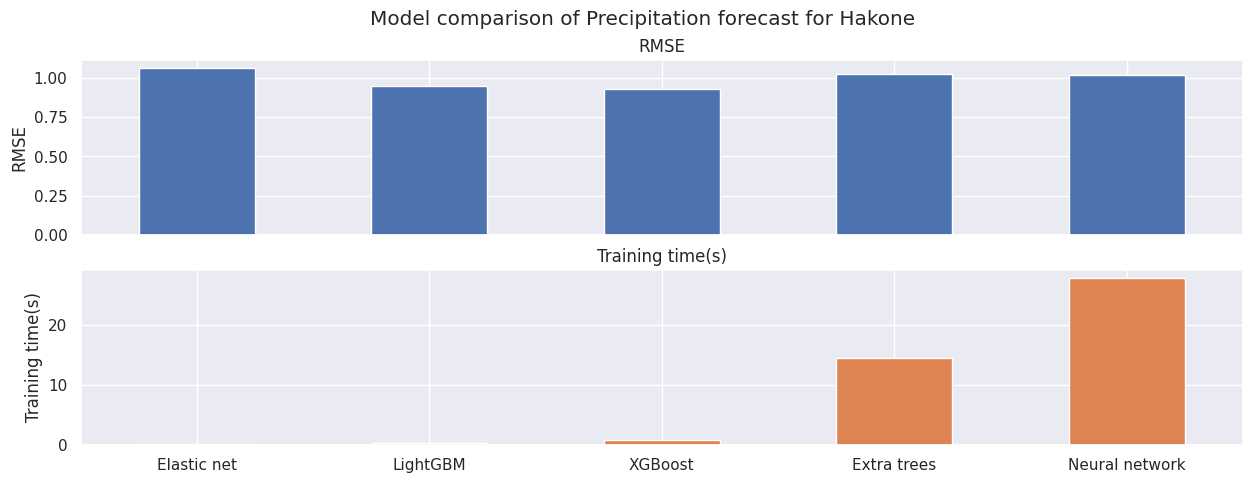

In [41]:
df_rmse = ex.val_rmse(scores, title='Model comparison of Precipitation forecast for Hakone')
df_rmse